In [1]:
!pip install gensim

In [2]:
import multiprocessing
import re
import nltk
import os

from gensim.models.word2vec import Word2Vec
from io import TextIOWrapper

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords', quiet=True)
cores = multiprocessing.cpu_count()

#Punto 1

In [3]:
def serialize_text(f: TextIOWrapper):
    begun = False
    full_text = []
    paragraph = ""

    for base_line in f:
        line = base_line.strip()

        if len(line) == 0:
            if len(paragraph) > 0:
                full_text.append(paragraph.strip())
                paragraph = ""

            continue

        if line.startswith("*** START OF THE PROJECT GUTENBERG EBOOK"):
            begun = True
            continue

        if line.startswith("*** END OF THE PROJECT GUTENBERG EBOOK"):
            break

        if begun:
            paragraph += line + " "

    return full_text

stemmer = SnowballStemmer('english')
stops = stopwords.words('english')

def tokenize(text: str):
    processed_feature = re.sub(r'\W', ' ', str(text))
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature)
    processed_feature = re.sub(r'[_\[\]\(\)]+', '', processed_feature)
    processed_feature = re.sub(' +', ' ', processed_feature)
    processed_feature = processed_feature.lower().strip()
    processed_feature = [stemmer.stem(i) for i in processed_feature.split()]
    processed_feature = " ".join([token for token in processed_feature if token not in stops])
    return processed_feature

In [5]:
base_path = "./books"
books = os.listdir(base_path)
sentences = []

for book in books:
  path = os.path.join(base_path, book)
  with open(path, encoding="utf-8") as f:
    lines = serialize_text(f)

    sentences_original = [line.strip() for text in lines for line in text.split(". ") if len(line.strip()) > 0]
    sentences_tokenized = [tokenize(sentence).split(" ") for sentence in sentences_original]
    sentences_tokenized = [token_list for token_list in sentences_tokenized if token_list[0] != '']
    sentences += sentences_tokenized

print(sentences)

[['execut', 'director', 'note'], ['addit', 'note', 'think', 'spell', 'error', 'introduc', 'printer', 'time', 'correct', 'first', 'line', 'hamlet', 'present', 'herein'], ['barnardo'], ['fran'], ['nay', 'answer', 'stand', 'vnfold', 'self'], ['bar'], ['long', 'liue', 'king'], ['understand', 'printer', 'often', 'ran', 'certain', 'word', 'letter', 'often', 'pack', 'clich'], ['origin', 'mean', 'term', 'clich'], ['thus', 'unwil', 'unpack', 'clich', 'thus', 'see', 'substitut', 'look', 'veri', 'odd'], ['exchang', 'v', 'abov'], ['may', 'wonder', 'whi', 'way', 'presum', 'shakespear', 'actual', 'write', 'play', 'manner'], ['answer', 'may', 'pack', 'liue', 'clich', 'time'], ['possibl', 'use', 'vv', 'place', 'etc'], ['common', 'practic', 'day', 'print', 'still', 'quit', 'expens', 'want', 'spend', 'wider', 'select', 'charact'], ['find', 'lot', 'kind', 'error', 'text', 'mention', 'time', 'place', 'mani', 'scholar', 'extrem', 'attach', 'error', 'mani', 'accord', 'veri', 'high', 'place', 'canon', 'shake

In [6]:
w2v_models = {}
vector_sizes = [1024, 512, 128]

for vector_size in vector_sizes:
  w2v_model = Word2Vec(
      min_count=5,
      window=3,
      vector_size=vector_size,
      workers=cores-1
      )

  w2v_model.build_vocab(sentences)
  w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30)

  w2v_models[vector_size] = w2v_model

In [7]:
os.makedirs("./vectors", exist_ok=True)

for vector_size in vector_sizes:
  path = f"./vectors/Books_{vector_size}_001"
  with open(f"{path}.txt", "w") as f:
      f.write("")

  with open(f"{path}.model", "w") as f:
      f.write("")

  w2v_models[vector_size].save(f"{path}.model")
  w2v_models[vector_size].wv.save_word2vec_format(f"{path}.txt")

Punto 2

In [8]:
import numpy as np
from sklearn.manifold import TSNE

In [15]:
from gensim.models.keyedvectors import KeyedVectors

tsne_vectors = TSNE(
    init='random',
    perplexity=50,
    n_jobs=cores-1
  ).fit_transform(w2v_models[1024].wv.vectors)

In [30]:
from sklearn.cluster import KMeans

n_clusters = 9
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(tsne_vectors)

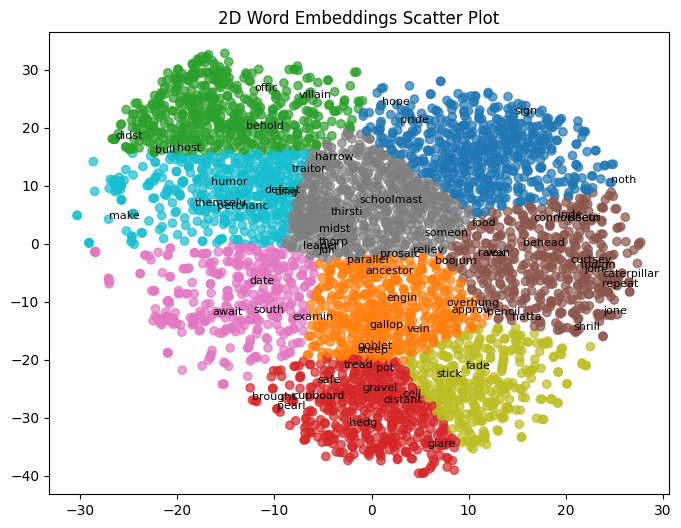

In [37]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(8, 6))
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], alpha=0.7, c=labels, cmap='tab10')

keys = w2v_models[1024].wv.index_to_key

num_labels = 70
random_indices = random.sample(range(len(keys)), num_labels)

for i in random_indices:
    plt.text(tsne_vectors[i, 0]+0.01, tsne_vectors[i, 1]+0.01, keys[i], fontsize=8)



plt.title("2D Word Embeddings Scatter Plot")
plt.show()